In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [12]:
class LateralBlock(nn.Module):
    def __init__(self,col,depth,block,out_shape, in_shapes):
        super(LateralBlock,self).__init__()
        self.col = col
        self.depth = depth 
        self.out_shape = out_shape
        self.block = block
        self.u = nn.ModuleList()
        
        
        if self.depth > 0: 
            self.u.extend([nn.Linear(in_shape,self.out_shape) for in_shape in in_shapes])


    def forward(self,inputs,activated = True):
        if not isinstance(inputs, list):
            inputs = [inputs]

        cur_column_out = self.block(inputs[-1])
        prev_columns_out = [mod(x) for mod, x in zip(self.u, inputs)] 
        res= cur_column_out + sum(prev_columns_out)
        if activated: 
            res = F.relu(res)
        return res
    
        

class ProgNet(nn.Module):
    def __init__(self,depth):
        super(ProgNet,self).__init__()
        
        self.columns = nn.ModuleList([])
        self.depth = depth
        
    
    def forward(self,x,task_id=-1):
        assert self.columns

        inputs = [col[0](x) for col in self.columns]
        for l in range(1,self.depth):
            out = []         
            for i,col in enumerate(self.columns):
                out.append(col[l](inputs[:i+1],activated = (l== self.depth - 1)))

            inputs = out
        return out[task_id]
        
    def new_task(self,new_layers,shapes):
        assert isinstance(new_layers,nn.Sequential)
        assert(len(new_layers) == len(shapes))
        
        task_id = len(self.columns)
        idx =[i for i,layer in enumerate(new_layers) if isinstance(layer,(nn.Conv2d,nn.Linear))] + [len(new_layers)]
        new_blocks = []
        
        for k in range(len(idx) -1): 
            prev_blocks = []
            if k > 0: 
                prev_blocks = [col[k-1] for col in self.columns]
                
            new_blocks.append(LateralBlock(col = task_id,
                                           depth = k,
                                           block = new_layers[idx[k]:idx[k+1]],
                                           out_shape = shapes[idx[k+1]-1],
                                           in_shapes = self._get_out_shape_blocks(prev_blocks)
                                          ))
        
        new_column = nn.ModuleList(new_blocks)
        self.columns.append(new_column)
            
            
        
    def _get_out_shape_blocks(self,blocks):
        assert isinstance(blocks,list)
        assert all(isinstance(block,LateralBlock) for block in blocks)
        return [block.out_shape for block in blocks]
        
        
    
    def freeze_columns(self, skip=None):
        if skip == None:
            skip = []

        for i, c in enumerate(self.columns):
            if i not in skip:
                for params in c.parameters():
                    params.requires_grad = False

In [234]:
net = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,1))
shapes = [16,16,32,32,1]
params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 609


In [235]:
pg = ProgNet(5)
params = sum(p.numel() for p in pg.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 0


In [236]:
pg.new_task(net,shapes)
params = sum(p.numel() for p in pg.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 609


In [237]:
pg.new_task(net,shapes)
params = sum(p.numel() for p in pg.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 1218


In [91]:
pg.columns[1]

ModuleList(
  (0): LateralBlock(
    (block): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): ReLU()
    )
    (u): ModuleList()
  )
  (1): LateralBlock(
    (block): Sequential(
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): ReLU()
    )
    (u): ModuleList(
      (0): Linear(in_features=16, out_features=32, bias=True)
    )
  )
  (2): LateralBlock(
    (block): Sequential(
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
    (u): ModuleList(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [34]:
net = nn.Sequential(
        nn.Conv2d(1,4,3,stride = 1, padding = 1), #out: (B,4,28,28)
        nn.ReLU(), 
        nn.BatchNorm2d(4),
        nn.MaxPool2d(2,stride = 2), #out: (B,4,14,14)
        nn.Conv2d(4,16,3,stride = 1, padding = 1), #out: (B,16,14,14)
        nn.ReLU(), 
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2,stride = 2), #out: (B,16,7,7)
        nn.Conv2d(16,32,3,stride = 1, padding = 1), #out: (B,32,7,7)
        nn.ReLU(), 
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,stride = 2), #out: (B,32,3,3)
        nn.Flatten(),
        nn.Linear(in_features = 32*3*3,out_features = 128),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(in_features = 128, out_features = 64), 
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(in_features = 64, out_features = 10))

shapes = [(4,28,28),
          (4,28,28),
          (4,28,28),
          (4,14,14),
          (16,14,14),
          (16,14,14),
          (16,14,14),
          (16,7,7),
          (32,7,7),
          (32,7,7),
          (32,7,7),
          (32,3,3),
          (128),
          (64),
          (10)]

In [24]:
idx = [i for i,layer in enumerate(net) if isinstance(layer,(nn.Conv2d,nn.Linear))]
for k in range(len(idx) -1): 
    print(net[idx[k]:idx[k+1]])

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten()
)
Sequential(
  (13): Linear(in_features=288, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
)
Sequential(
  (16): Linear(in_features=128, ou

In [35]:
type(net[0:4])

torch.nn.modules.container.Sequential

# MNIST Classification

In [13]:
#data loading
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [14]:
data = next(iter(train_loader))

In [15]:
img,_ = data
net(img).shape

NameError: name 'net' is not defined

In [362]:
#model definition
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.conv_layers = nn.Sequential(
        nn.Conv2d(1,4,3,stride = 1, padding = 1), #out: (B,4,28,28)
        nn.ReLU(), 
        nn.BatchNorm2d(4),
        nn.MaxPool2d(2,stride = 2), #out: (B,4,14,14)
        nn.Conv2d(4,16,3,stride = 1, padding = 1), #out: (B,16,14,14)
        nn.ReLU(), 
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2,stride = 2), #out: (B,16,7,7)
        nn.Conv2d(16,32,3,stride = 1, padding = 1), #out: (B,32,7,7)
        nn.ReLU(), 
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,stride = 2)) #out: (B,32,3,3)
        
        self.classifier = nn.Sequential(
        nn.Linear(in_features = 32*3*3,out_features = 128),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(in_features = 128, out_features = 64), 
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(in_features = 64, out_features = 10))
        
    def forward(self,x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x

In [77]:
model = MyNet()
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 51274
MyNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inp

In [78]:
#Training
learning_rate = 0.001
num_epochs = 10

optimizer = optim.Adam(model.parameters(),
                       lr = learning_rate)
criterion = F.cross_entropy


In [79]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img, y = data
        optimizer.zero_grad()
        # forward
        y_pred = model(img)
        loss = criterion(y_pred, y,reduction = 'mean')
        # backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(train_loader)))

    train_losses.append(train_loss/ len(train_loader))




epoch [1/10], loss:0.3411
epoch [2/10], loss:0.1091
epoch [3/10], loss:0.0876
epoch [4/10], loss:0.0727
epoch [5/10], loss:0.0657
epoch [6/10], loss:0.0600
epoch [7/10], loss:0.0523
epoch [8/10], loss:0.0496
epoch [9/10], loss:0.0469
epoch [10/10], loss:0.0454


## Classification with ProgNet: fully connected network

In [126]:
def make_column(activated = True): 
    if activated: 
        model = nn.Sequential(nn.Linear(28*28*1,128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(), 
                      nn.Linear(64,32),
                      nn.ReLU(),
                      nn.Linear(32,10))
    else: 
        model = nn.Sequential(nn.Linear(28*28*1,128),
                      #nn.ReLU(),
                      nn.Linear(128,64),
                      #nn.ReLU(), 
                      nn.Linear(64,32),
                      #nn.ReLU(),
                      nn.Linear(32,10))
    return model
shapes_activated = [128,128,64,64,32,32,10]
shapes = [128,64,32,10]


In [127]:
prog_net = ProgNet(depth = 3)
dummy_net = make_column(activated = True).to(device)
prog_net.new_task(copy.deepcopy(dummy_net)[0:7:2],shapes)
prog_net = prog_net.to(device)


params = sum(p.numel() for p in prog_net.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(prog_net)

Total number of parameters is: 111146
ProgNet(
  (columns): ModuleList(
    (0): ModuleList(
      (0): LateralBlock(
        (block): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
        )
        (u): ModuleList()
      )
      (1): LateralBlock(
        (block): Sequential(
          (2): Linear(in_features=128, out_features=64, bias=True)
        )
        (u): ModuleList()
      )
      (2): LateralBlock(
        (block): Sequential(
          (4): Linear(in_features=64, out_features=32, bias=True)
        )
        (u): ModuleList()
      )
      (3): LateralBlock(
        (block): Sequential(
          (6): Linear(in_features=32, out_features=10, bias=True)
        )
        (u): ModuleList()
      )
    )
  )
)


In [128]:
#data loading
batch_size_train = 64
batch_size_test = 1000

dataset_train = torchvision.datasets.MNIST('./data', train=True, download=True,
                                     transform = torchvision.transforms.Compose([
                                                 torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize(
                                                 (0.1307,), (0.3081,))]))
dataset_test_0 = torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_loader_full = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

data = dataset_train.data
data_test = dataset_test_0.data
targets = dataset_train.targets
targets_test = dataset_test_0.targets

In [129]:
split_idx_train = [(dataset_train.targets ==i).tolist() for i in range(10)]
split_idx_test =[(dataset_test_0.targets ==i).tolist() for i in range(10)]

### Training phase  1 
Column 0, digits 0 to 4

In [130]:
mask_digits_train_0 = [any(tupl) for tupl in zip(split_idx_train[0],
                                                   split_idx_train[1],
                                                   split_idx_train[2],
                                                   split_idx_train[3],
                                                   split_idx_train[4])]

mask_digits_test_0 = [any(tupl) for tupl in zip(split_idx_test[0],
                                                   split_idx_test[1],
                                                   split_idx_test[2],
                                                   split_idx_test[3],
                                                   split_idx_test[4])]
dataset_train.data = data[mask_digits_train_0]
dataset_train.targets = targets[mask_digits_train_0]

dataset_test_0.data = data_test[mask_digits_test_0]
dataset_test_0.targets = targets_test[mask_digits_test_0]

train_loader = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size_train, shuffle=True)

test_loader_0 = torch.utils.data.DataLoader(
  dataset_test_0,
  batch_size=batch_size_test, shuffle=True)

In [131]:
#Training
learning_rate = 0.0001
num_epochs = 10

optimizer = optim.Adam(prog_net.parameters(),
                       lr = learning_rate)
optimizer_d = optim.Adam(dummy_net.parameters(),
                       lr = learning_rate)
criterion = F.cross_entropy

In [132]:
def model_eval(model,dataloader,task_id = -1):
    model.eval()
    with torch.no_grad(): 
        eval_loss = 0
        for batch_idx, data in enumerate(dataloader): 
            img,y = data
            img = img.view(img.shape[0],-1)
            img = img.to(device)
            y = y.to(device)
            if isinstance(model,ProgNet):
                y_pred = model(img,task_id = task_id)
            else: 
                y_pred = model(img)
            loss = criterion(y_pred,y,reduction = 'mean')
            eval_loss += loss.item()
    
    model.train()
    return eval_loss/len(dataloader)

In [133]:
train_losses = []
train_losses_d = []
test_losses_full = []
test_losses = []
test_losses_d_full = []
test_losses_d = []

prog_net.train()
dummy_net.train()
for epoch in range(num_epochs):
    train_loss = 0
    train_loss_d = 0
    for batch_idx, data in enumerate(train_loader):
        img, y = data
        img = img.view(img.shape[0],-1)
        img = img.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        optimizer_d.zero_grad()
        # forward
        y_pred = prog_net(img)
        y_pred_d = dummy_net(img)
        loss = criterion(y_pred, y,reduction = 'mean')
        loss_d = criterion(y_pred_d, y,reduction = 'mean')
        # backward
        loss.backward()
        loss_d.backward()
        train_loss += loss.item()
        train_loss_d += loss_d.item()
        optimizer.step()
        optimizer_d.step()
    print('epoch [{}/{}], ProgNet loss:{:.4f}, DummyNet loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(train_loader),train_loss_d/len(train_loader)))

    train_losses.append(train_loss/ len(train_loader))
    train_losses_d.append(train_loss_d/ len(train_loader))
    
    test_losses.append(model_eval(prog_net,test_loader_0))
    test_losses_d.append(model_eval(dummy_net,test_loader_0))
    test_losses_full.append(model_eval(prog_net,test_loader_full))
    test_losses_d_full.append(model_eval(dummy_net,test_loader_full))

epoch [1/10], ProgNet loss:1.2708, DummyNet loss:0.5730
epoch [2/10], ProgNet loss:0.3498, DummyNet loss:0.1199
epoch [3/10], ProgNet loss:0.0980, DummyNet loss:0.0975
epoch [4/10], ProgNet loss:0.0821, DummyNet loss:0.0839
epoch [5/10], ProgNet loss:0.0700, DummyNet loss:0.0736
epoch [6/10], ProgNet loss:0.0599, DummyNet loss:0.0653
epoch [7/10], ProgNet loss:0.0517, DummyNet loss:0.0580
epoch [8/10], ProgNet loss:0.0445, DummyNet loss:0.0517
epoch [9/10], ProgNet loss:0.0389, DummyNet loss:0.0465
epoch [10/10], ProgNet loss:0.0337, DummyNet loss:0.0414


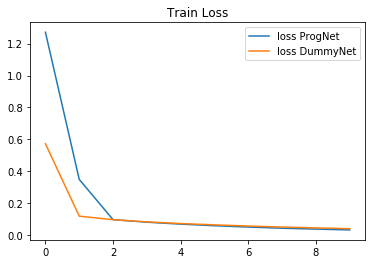

In [134]:
plt.plot(list(range(0,len(train_losses))), train_losses, label='loss ProgNet')
plt.plot(list(range(0,len(train_losses_d))), train_losses_d, label='loss DummyNet')
plt.legend()
plt.title('Train Loss')
plt.show()

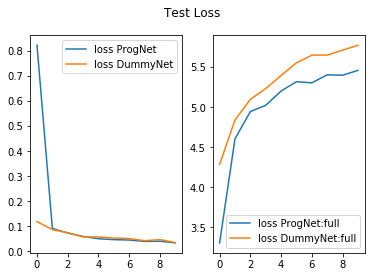

In [135]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle('Test Loss')

ax1.plot(list(range(0,len(test_losses))), test_losses, label='loss ProgNet')
ax1.plot(list(range(0,len(test_losses_d))), test_losses_d, label='loss DummyNet')
ax2.plot(list(range(0,len(test_losses_full))), test_losses_full, label='loss ProgNet:full')
ax2.plot(list(range(0,len(test_losses_d_full))), test_losses_d_full, label='loss DummyNet:full')
ax1.legend()
ax2.legend()
plt.show()

### Training Phase 2
Column 1, digits 5 to 9

In [136]:
#data loading
batch_size_train = 64
batch_size_test = 1000

dataset_train = torchvision.datasets.MNIST('./data', train=True, download=True,
                                     transform = torchvision.transforms.Compose([
                                                 torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize(
                                                 (0.1307,), (0.3081,))]))
dataset_test_1 = torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_loader_full = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

data = dataset_train.data
data_test = dataset_test_1.data
targets = dataset_train.targets
targets_test = dataset_test_1.targets

In [137]:
mask_digits_train_1 = [any(tupl) for tupl in zip(split_idx_train[5],
                                                   split_idx_train[6],
                                                   split_idx_train[7],
                                                   split_idx_train[8],
                                                   split_idx_train[9])]

mask_digits_test_1 = [any(tupl) for tupl in zip(split_idx_test[5],
                                                   split_idx_test[6],
                                                   split_idx_test[7],
                                                   split_idx_test[8],
                                                   split_idx_test[9])]
dataset_train.data = data[mask_digits_train_1]
dataset_train.targets = targets[mask_digits_train_1]

dataset_test_1.data = data_test[mask_digits_test_1]
dataset_test_1.targets = targets_test[mask_digits_test_1]

train_loader = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size_train, shuffle=True)

test_loader_1 = torch.utils.data.DataLoader(
  dataset_test_1,
  batch_size=batch_size_test, shuffle=True)

In [138]:
prog_net.freeze_columns()
prog_net.new_task(make_column(activated = False),shapes)
prog_net = prog_net.to(device)

params = sum(p.numel() for p in prog_net.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(prog_net)

Total number of parameters is: 121812
ProgNet(
  (columns): ModuleList(
    (0): ModuleList(
      (0): LateralBlock(
        (block): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
        )
        (u): ModuleList()
      )
      (1): LateralBlock(
        (block): Sequential(
          (2): Linear(in_features=128, out_features=64, bias=True)
        )
        (u): ModuleList()
      )
      (2): LateralBlock(
        (block): Sequential(
          (4): Linear(in_features=64, out_features=32, bias=True)
        )
        (u): ModuleList()
      )
      (3): LateralBlock(
        (block): Sequential(
          (6): Linear(in_features=32, out_features=10, bias=True)
        )
        (u): ModuleList()
      )
    )
    (1): ModuleList(
      (0): LateralBlock(
        (block): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
        )
        (u): ModuleList()
      )
      (1): LateralBlock(
        (block): Sequential(
 

In [139]:
#Training
learning_rate = 0.0001
num_epochs = 10

optimizer = optim.Adam(prog_net.parameters(),
                       lr = learning_rate)
optimizer_d = optim.Adam(dummy_net.parameters(),
                       lr = learning_rate)
criterion = F.cross_entropy

In [140]:
prog_net.train()
dummy_net.train()
for epoch in range(num_epochs):
    train_loss = 0
    train_loss_d = 0
    for batch_idx, data in enumerate(train_loader):
        img, y = data
        img = img.view(img.shape[0],-1)
        img = img.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        optimizer_d.zero_grad()
        # forward
        y_pred = prog_net(img)
        y_pred_d = dummy_net(img)
        loss = criterion(y_pred, y,reduction = 'mean')
        loss_d = criterion(y_pred_d, y,reduction = 'mean')
        # backward
        loss.backward()
        loss_d.backward()
        train_loss += loss.item()
        train_loss_d += loss_d.item()
        optimizer.step()
        optimizer_d.step()
    print('epoch [{}/{}], ProgNet loss:{:.4f}, DummyNet loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(train_loader),train_loss_d/len(train_loader)))

    train_losses.append(train_loss/ len(train_loader))
    train_losses_d.append(train_loss_d/ len(train_loader))
    
    test_losses.append(model_eval(prog_net,test_loader_1,task_id = 1))
    test_losses_d.append(model_eval(dummy_net,test_loader_1))
    test_losses_full.append((model_eval(prog_net,test_loader_0,task_id = 0) + model_eval(prog_net,test_loader_1,task_id = 1))/2)
    test_losses_d_full.append(model_eval(dummy_net,test_loader_full))

epoch [1/10], ProgNet loss:1.0051, DummyNet loss:2.2715
epoch [2/10], ProgNet loss:0.1740, DummyNet loss:0.3080
epoch [3/10], ProgNet loss:0.1336, DummyNet loss:0.1857
epoch [4/10], ProgNet loss:0.1107, DummyNet loss:0.1481
epoch [5/10], ProgNet loss:0.0951, DummyNet loss:0.1249
epoch [6/10], ProgNet loss:0.0818, DummyNet loss:0.1065
epoch [7/10], ProgNet loss:0.0725, DummyNet loss:0.0934
epoch [8/10], ProgNet loss:0.0637, DummyNet loss:0.0823
epoch [9/10], ProgNet loss:0.0567, DummyNet loss:0.0732
epoch [10/10], ProgNet loss:0.0505, DummyNet loss:0.0655


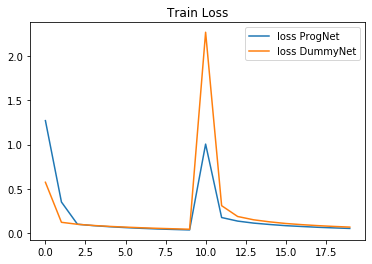

In [141]:
plt.plot(list(range(0,len(train_losses))), train_losses, label='loss ProgNet')
plt.plot(list(range(0,len(train_losses_d))), train_losses_d, label='loss DummyNet')
plt.legend()
plt.title('Train Loss')
plt.show()

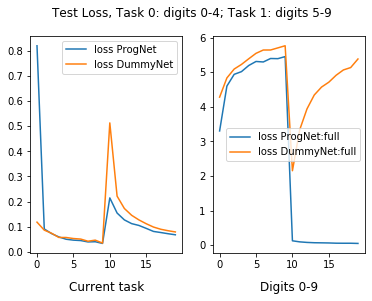

In [142]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle('Test Loss, Task 0: digits 0-4; Task 1: digits 5-9')

ax1.plot(list(range(0,len(test_losses))), test_losses, label='loss ProgNet')
ax1.plot(list(range(0,len(test_losses_d))), test_losses_d, label='loss DummyNet')
ax2.plot(list(range(0,len(test_losses_full))), test_losses_full, label='loss ProgNet:full')
ax2.plot(list(range(0,len(test_losses_d_full))), test_losses_d_full, label='loss DummyNet:full')
ax1.set_title('Current task', y = - 0.2)
ax2.set_title('Digits 0-9',y = - 0.2)
ax1.legend()
ax2.legend()
plt.show()

## Classification with ProgNet: Convolutional network